In [ ]:
!pip install -q datasets sentencepiece tensorboard


In [ ]:
!brew install git-lfs

In [1]:
from huggingface_hub import notebook_login
 
notebook_login()

In [2]:
%%bash
# clone repository
git clone https://github.com/zzzDavid/ICDAR-2019-SROIE.git
# copy data
cp -r ICDAR-2019-SROIE/data ./
# clean up
rm -rf ICDAR-2019-SROIE
rm -rf data/box

Cloning into 'ICDAR-2019-SROIE'...
Updating files: 100% (1980/1980), done.


In [3]:
import os
import json
from pathlib import Path
import shutil
 
# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
# define metadata list
metadata_list = []
 
# parse metadata
for file_name in metadata_path.glob("*.json"):
  with open(file_name, "r") as json_file:
    # load json file
    data = json.load(json_file)
    # create "text" column with json string
    text = json.dumps(data)
    # add to metadata list if image exists
    if image_path.joinpath(f"{file_name.stem}.jpg").is_file():
      metadata_list.append({"text":text,"file_name":f"{file_name.stem}.jpg"})
      # delete json file
 
# write jsonline file
with open(image_path.joinpath('metadata.jsonl'), 'w') as outfile:
    for entry in metadata_list:
        json.dump(entry, outfile)
        outfile.write('\n')
 
# remove old meta data
shutil.rmtree(metadata_path)

In [4]:
import os
import json
from pathlib import Path
import shutil
from datasets import load_dataset
 
# define paths
base_path = Path("data")
metadata_path = base_path.joinpath("key")
image_path = base_path.joinpath("img")
 
# Load dataset
dataset = load_dataset("imagefolder", data_dir=image_path, split="train")
 
print(f"Dataset has {len(dataset)} images")
print(f"Dataset features are: {dataset.features.keys()}")

Resolving data files:   0%|          | 0/627 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset has 626 images
Dataset features are: dict_keys(['image', 'text'])


Random sample is 403
OCR text is {"company": "MR. D.I.Y. (M) SDN BHD", "date": "22-04-16", "address": "LOT 1851-A & 1851-B, JALAN KPB 6, KAWASAN PERINDUSTRIAN BALAKONG, 43300 SERI KEMBANGAN, SELANGOR", "total": "RM 68.10"}


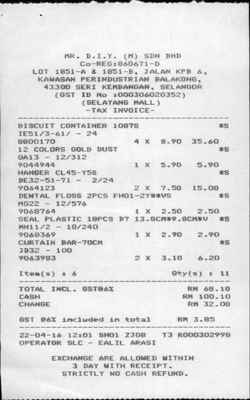

In [5]:
import random
 
random_sample = random.randint(0, len(dataset))
 
print(f"Random sample is {random_sample}")
print(f"OCR text is {dataset[random_sample]['text']}")
dataset[random_sample]['image'].resize((250,400))
#     OCR text is {"company": "LIM SENG THO HARDWARE TRADING", "date": "29/12/2017", "address": "NO 7, SIMPANG OFF BATU VILLAGE, JALAN IPOH BATU 5, 51200 KUALA LUMPUR MALAYSIA", "total": "6.00"}

In [6]:
new_special_tokens = [] # new tokens which will be added to the tokenizer
task_start_token = "<s>"  # start of task token
eos_token = "</s>" # eos token of tokenizer
 
def json2token(obj, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(obj) == dict:
        if len(obj) == 1 and "text_sequence" in obj:
            return obj["text_sequence"]
        else:
            output = ""
            if sort_json_key:
                keys = sorted(obj.keys(), reverse=True)
            else:
                keys = obj.keys()
            for k in keys:
                if update_special_tokens_for_json_key:
                    new_special_tokens.append(fr"<s_{k}>") if fr"<s_{k}>" not in new_special_tokens else None
                    new_special_tokens.append(fr"</s_{k}>") if fr"</s_{k}>" not in new_special_tokens else None
                output += (
                    fr"<s_{k}>"
                    + json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                    + fr"</s_{k}>"
                )
            return output
    elif type(obj) == list:
        return r"<sep/>".join(
            [json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
        )
    else:
        # excluded special tokens for now
        obj = str(obj)
        if f"<{obj}/>" in new_special_tokens:
            obj = f"<{obj}/>"  # for categorical special tokens
        return obj
 
 
def preprocess_documents_for_donut(sample):
    # create Donut-style input
    text = json.loads(sample["text"])
    d_doc = task_start_token + json2token(text) + eos_token
    # convert all images to RGB
    image = sample["image"].convert('RGB')
    return {"image": image, "text": d_doc}
 
proc_dataset = dataset.map(preprocess_documents_for_donut)
 
print(f"Sample: {proc_dataset[45]['text']}")
print(f"New special tokens: {new_special_tokens + [task_start_token] + [eos_token]}")
#    Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
#    New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Sample: <s><s_total>$6.90</s_total><s_date>27 MAR 2018</s_date><s_company>UNIHAKKA INTERNATIONAL SDN BHD</s_company><s_address>12, JALAN TAMPOI 7/4,KAWASAN PARINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR</s_address></s>
New special tokens: ['<s_total>', '</s_total>', '<s_date>', '</s_date>', '<s_company>', '</s_company>', '<s_address>', '</s_address>', '<s>', '</s>']


In [7]:
from transformers import DonutProcessor
 
# Load processor
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
 
# add new special tokens to tokenizer
processor.tokenizer.add_special_tokens({"additional_special_tokens": new_special_tokens + [task_start_token] + [eos_token]})
 
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# resizing the image to smaller sizes from [1920, 2560] to [960,1280]
processor.feature_extractor.size = [720,960] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/Users/kunnummaln/venv-metal/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/kunnummaln/venv-metal/lib/python3.11/site-packages/transformers/models/donut/processing_donut.py:193: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [8]:
def transform_and_tokenize(sample, processor=processor, split="train", max_length=512, ignore_id=-100):
    # create tensor from image
    try:
        pixel_values = processor(
            sample["image"], random_padding=split == "train", return_tensors="pt"
        ).pixel_values.squeeze()
    except Exception as e:
        print(sample)
        print(f"Error: {e}")
        return {}
 
    # tokenize document
    input_ids = processor.tokenizer(
        sample["text"],
        add_special_tokens=False,
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)
 
    labels = input_ids.clone()
    labels[labels == processor.tokenizer.pad_token_id] = ignore_id  # model doesn't need to predict pad token
    return {"pixel_values": pixel_values, "labels": labels, "target_sequence": sample["text"]}
 
# need at least 32-64GB of RAM to run this
processed_dataset = proc_dataset.map(transform_and_tokenize,remove_columns=["image","text"])

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

In [9]:
processed_dataset = processed_dataset.train_test_split(test_size=0.1)
print(processed_dataset)

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 563
    })
    test: Dataset({
        features: ['pixel_values', 'labels', 'target_sequence'],
        num_rows: 63
    })
})


In [10]:
import torch
from transformers import VisionEncoderDecoderModel, VisionEncoderDecoderConfig
 
# Load model from huggingface.co
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base")
 
# Resize embedding layer to match vocabulary size
new_emb = model.decoder.resize_token_embeddings(len(processor.tokenizer))
print(f"New embedding size: {new_emb}")
# Adjust our image size and output sequence lengths
model.config.encoder.image_size = processor.feature_extractor.size[::-1] # (height, width)
model.config.decoder.max_length = len(max(processed_dataset["train"]["labels"], key=len))
 
# Add task token for decoder to start
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]
 
# is done by Trainer
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.to(device)

New embedding size: MBartScaledWordEmbedding(57533, 1024, padding_idx=1)


/Users/kunnummaln/venv-metal/lib/python3.11/site-packages/transformers/models/donut/processing_donut.py:193: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [11]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
 
# hyperparameters used for multiple args
hf_repository_id = "donut-base-sroie"
 
# Arguments for training
training_args = Seq2SeqTrainingArguments(
    output_dir=hf_repository_id,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    weight_decay=0.01,
    fp16=False,
    use_mps_device=True,
    logging_steps=100,
    save_total_limit=2,
    evaluation_strategy="no",
    save_strategy="epoch",
    predict_with_generate=True,
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=True,
    hub_strategy="every_save",
    hub_model_id=hf_repository_id,
    hub_token=HfFolder.get_token(),
)
 
# Create Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
)

/Users/kunnummaln/venv-metal/lib/python3.11/site-packages/transformers/training_args.py:1528: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/Users/kunnummaln/venv-metal/lib/python3.11/site-packages/transformers/training_args.py:2182: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


In [12]:
# Start training
trainer.train()

Step,Training Loss
100,3.386100
200,1.146100
300,0.685100
400,0.576600
500,0.536300
600,0.468700
700,0.390700
800,0.350600


TrainOutput(global_step=846, training_loss=0.9127489725748698, metrics={'train_runtime': 1776.2967, 'train_samples_per_second': 0.951, 'train_steps_per_second': 0.476, 'total_flos': 2.970761500447949e+18, 'train_loss': 0.9127489725748698, 'epoch': 3.0})

In [13]:
# Save processor and create model card
processor.save_pretrained(hf_repository_id)
trainer.create_model_card()
trainer.push_to_hub()

sentencepiece.bpe.model:   0%|          | 0.00/1.30M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1724419421.MacBook-Pro.fios-router.home.46666.0:   0%|          | 0.00/11.4k [00:00<?, ?B/…

CommitInfo(commit_url='https://huggingface.co/naheedmk/donut-base-sroie/commit/e3f2e48a85ebde4dcc378ad0978f9c3ce81ce8ad', commit_message='End of training', commit_description='', oid='e3f2e48a85ebde4dcc378ad0978f9c3ce81ce8ad', pr_url=None, pr_revision=None, pr_num=None)

In [39]:
import re
import transformers
from PIL import Image
from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import random
import numpy as np
from PIL import Image

# hidde logs
transformers.logging.disable_default_handler()
 
 
# Load our model from Hugging Face
processor = DonutProcessor.from_pretrained("philschmid/donut-base-sroie")
model = VisionEncoderDecoderModel.from_pretrained("philschmid/donut-base-sroie")
 
# Move model to GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
 
# Load random document image from the test set
test_sample = processed_dataset["test"][random.randint(1, 50)]
 
def run_prediction(sample, model=model, processor=processor):
    # prepare inputs
    pixel_values = torch.tensor(test_sample["pixel_values"]).unsqueeze(0)
    task_prompt = "<s>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
 
    # run inference
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_position_embeddings,
        early_stopping=True,
        pad_token_id=processor.tokenizer.pad_token_id,
        eos_token_id=processor.tokenizer.eos_token_id,
        use_cache=True,
        num_beams=1,
        bad_words_ids=[[processor.tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )
 
    # process output
    prediction = processor.batch_decode(outputs.sequences)[0]
    prediction = processor.token2json(prediction)
 
    # load reference target
    target = processor.token2json(test_sample["target_sequence"])
    return prediction, target
 
prediction, target = run_prediction(test_sample)
print(f"Reference:\n {target}")
print(f"Prediction:\n {prediction}")
#processor.feature_extractor.to_pil_image(np.array(test_sample["pixel_values"])).resize((350,600))
image_array = np.array(test_sample["pixel_values"])

# Check the shape and data type of the array
print(f"Original array shape: {image_array.shape}, data type: {image_array.dtype}")
image_array = (255 * (image_array - np.min(image_array)) / np.ptp(image_array)).astype(np.uint8)

image_array = np.transpose(image_array, (1, 2, 0))

# Now the shape should be (height, width, channels)
print(f"Rearranged array shape: {image_array.shape}")

# Convert the numpy array to a PIL image
pil_image = Image.fromarray(image_array)

# Display the image or perform further operations
pil_image.show()


/Users/kunnummaln/venv-metal/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/Users/kunnummaln/venv-metal/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:615: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Reference:
 {'total': 'RM7.70', 'date': '09 JUN 2018', 'company': 'UNIHAKKA INTERNATIONAL SDN BHD', 'address': '12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR'}
Prediction:
 {'total': 'RM7.70', 'date': '18 JUN 2018', 'company': 'UNIHAKKA INTERNATIONAL SDN BHD', 'address': '12, JALAN TAMPOI 7/4,KAWASAN PERINDUSTRIAN TAMPOI,81200 JOHOR BAHRU,JOHOR'}
Original array shape: (3, 960, 720), data type: float64
Rearranged array shape: (960, 720, 3)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
